In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt

from dispersant_screener.utils import get_maxmin_samples, get_hypervolume, read_pickle, get_random_exploration_bl, is_pareto_efficient
from dispersant_screener.definitions import FEATURES
from sklearn.preprocessing import StandardScaler
from glob import glob 
import os

DATADIR = 'data'
from functools import partial
from matplotlib import animation, rc

COLORS = [
    "#ffbe0b", 
    "#fb5607", 
    "#ff006e",
    "#3a86ff", 
]

plt.rcParams['font.family'] = 'sans-serif'

In [4]:
discarded = np.load('work/sweep2/202010', allow_pickle=True)
unclassified = np.load('work/sweep2/20201014-1006540.05_0.05_0.1111111111111111_60-unclassified.npy', allow_pickle=True)
pareto_optimal = np.load('work/sweep2/20201014-1006540.05_0.05_0.1111111111111111_60-pareto_optimal_indices.npy', allow_pickle=True)
selected = np.load('work/sweep2/20201014-1006540.05_0.05_0.1111111111111111_60-selected.npy', allow_pickle=True)

greedy_indices = np.load('work/sweep2/20201014-1006540.05_0.05_0.1111111111111111_60-greedy_indices.npy', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'work/sweep2/20201014-100654'

In [4]:
hvs = list(np.load('work/sweep2/20201012-1641530.05_0.05_0.1111111111111111_60-hypervolumes.npy', allow_pickle=True))

In [28]:
hvs_0 = list(np.load('work/sweep2/20201014-1006500.01_0.05_0.1111111111111111_60-hypervolumes.npy', allow_pickle=True))
hvs_1 = list(np.load('work/sweep2/20201014-1006540.05_0.05_0.1111111111111111_60-hypervolumes.npy', allow_pickle=True))
hvs_2 = list(np.load('work/sweep2/20201014-1006540.1_0.05_0.1111111111111111_60-hypervolumes.npy', allow_pickle=True))
hvs_3 = list(np.load('work/sweep2/20201014-1007000.01_0.05_0.1111111111111111_100-hypervolumes.npy', allow_pickle=True))
hvs_4 = list(np.load('work/sweep2/20201014-1007030.1_0.05_0.1111111111111111_100-hypervolumes.npy', allow_pickle=True))
hvs_5 = list(np.load('work/sweep2/20201014-1007090.05_0.05_0.1111111111111111_100-hypervolumes.npy', allow_pickle=True))

In [29]:
for hv in [hvs_0, hvs_1, hvs_2, hvs_3, hvs_4, hvs_5]: 
    print(hv[-1])

1531.5874030015502
1505.4384599862167
1512.5556493423114
1530.6612886528562
1507.3633318781908
1516.7880721752333


In [5]:
hvs_padded = np.array([hvs[0]] * 60 + hvs)

In [6]:
hvs_b = list(np.load('work/sweep2/20201012-1641530.1_0.05_0.1111111111111111_60-hypervolumes.npy', allow_pickle=True))

In [7]:
hvs_b_padded = np.array([hvs_b[0]] * 60 + hvs_b)

In [5]:
def get_summary_stats_time(): 
    pareto_points = []
    non_pareto_points = []
    sampled_points = []
    unclassified_points = []
    
    for array in pareto_optimal:
        pareto_points.append(len(array))
        
    for array in discarded:
        non_pareto_points.append(len(array))
    
    for array in selected:
        sampled_points.append(len(array))
        
    for array in unclassified: 
        unclassified_points.append(len(array))
    
    return pareto_points, non_pareto_points, sampled_points, unclassified_points

In [6]:
pareto_points, non_pareto_points, sampled_points, unclassified_points = get_summary_stats_time()

NameError: name 'pareto_optimal' is not defined

In [10]:
def load_data(n_samples, label_scaling: bool = False):
    """Take in Brian's data and spit out some numpy arrays for the PAL"""
    df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
    a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
    deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values  # pylint:disable=unused-variable
    gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values * (-1)
    gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
    force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values  # pylint:disable=unused-variable
    rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
    y = np.hstack([rg.reshape(-1, 1), gibbs.reshape(-1, 1), gibbs_max.reshape(-1, 1)])
    assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

    feat_scaler = StandardScaler()
    X = feat_scaler.fit_transform(df_full_factorial_feat)

    if label_scaling:
        label_scaler = MinMaxScaler()
        y = label_scaler.fit_transform(y)

    #greedy_indices = get_maxmin_samples(X, n_samples)

    return X, y#, greedy_indice

In [11]:
X, y = load_data(1)

In [12]:
len(y)

3125

In [13]:
REFERENCE_HV = get_hypervolume(y, [5,5,5])

In [14]:
def get_settings_from_filename(filename):
    parts = filename.split('_')

    alpha_parts = parts[0].split('.')
    decimal = alpha_parts[-1]
    full_part = alpha_parts[0][-1]
    alpha = float(f'{full_part}.{decimal}')

    delta = float(parts[1])
    beta_scale = float(parts[2])
    n_samples = int(parts[3].split('-')[0])
    data_type = parts[3].split('-')[-1].split('.')[0]
    
    
    return { 
        'name': filename, 
        'alpha': alpha, 
        'delta': delta, 
        'beta_scale': beta_scale,
        'n_samples': n_samples, 
        'data_type': data_type
    }

In [15]:
all_hv_files = glob('work/sweep2/*-hypervolumes.npy')

In [16]:
results = []
for file in all_hv_files: 
    meta = get_settings_from_filename(file)
    hv = np.load(file)
    
    error = (REFERENCE_HV-hv[-1])/REFERENCE_HV
    
    meta['error'] = error * 100
    meta['iterations'] = len(hv)
    
    results.append(meta)

In [17]:
df = pd.DataFrame(results)

In [18]:
df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][3]) & (df['delta']==0.01)].sort_values(by='error')

,name,alpha,delta,beta_scale,n_samples,data_type,error,iterations
87,work/sweep2/20201007-1656420.05_0.01_0.1111111...,0.05,0.01,0.111111,60,hypervolumes,1.393639,283
93,work/sweep2/20201007-1656520.1_0.01_0.11111111...,0.10,0.01,0.111111,60,hypervolumes,2.206401,163


In [19]:
1/16

0.0625

/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  del sys.path[0]
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  


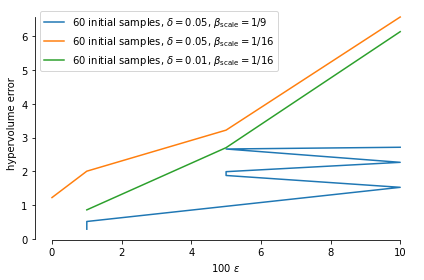

In [20]:
fig, ax = plt.subplots(1,1)

subset0 = df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][3]) & (df['delta']==0.05)].sort_values(by='error')
subset1 = df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][2]) & (df['delta']==0.05)].sort_values(by='error')
subset2 = df[(df['n_samples']==60) & (df['beta_scale']==df['beta_scale'][2]) & (df['delta']==0.01) & (df['alpha']>0)].sort_values(by='error')

ax.plot(subset0['alpha'] * 100, subset0['error'], label=r'60 initial samples, $\delta=0.05$, $\beta_\mathrm{scale}=1/9$')
ax.plot(subset1['alpha'] * 100, subset1['error'], label=r'60 initial samples, $\delta=0.05$, $\beta_\mathrm{scale}=1/16$')
ax.plot(subset2['alpha'] * 100, subset2['error'], label=r'60 initial samples, $\delta=0.01$, $\beta_\mathrm{scale}=1/16$')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)


ax.set_xlabel(r'$100\ \epsilon$')
ax.set_ylabel(r'hypervolume error')
ax.legend()

fig.tight_layout()
fig.savefig('some_parameter_settings.pdf', bbox_inches='tight')

In [21]:
random_explorations = np.load('notebooks/random_exploration.npy')

In [22]:
random_exploration_median = np.median(random_explorations, axis=0)
random_exploration_std = np.std(random_explorations, axis=0)

/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  if sys.path[0] == '':
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  del sys.path[0]
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in

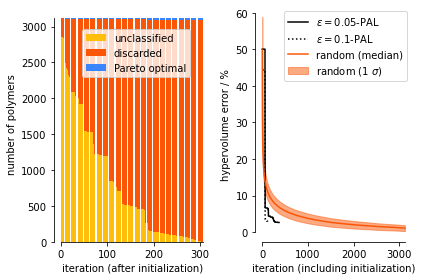

In [23]:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1]})
ax[0].bar(range(len(pareto_optimal)), unclassified_points, label='unclassified', color=COLORS[0])
ax[0].bar(range(len(pareto_optimal)), non_pareto_points, bottom=unclassified_points, label='discarded', color=COLORS[1])
ax[0].bar(range(len(pareto_optimal)), 
          pareto_points, bottom=np.array(non_pareto_points)+ np.array(unclassified_points), 
          label='Pareto optimal', color=COLORS[3])
ax[0].set_xlabel('iteration (after initialization)')
ax[1].set_xlabel('iteration (including initialization)')
ax[0].set_ylabel('number of polymers')
ax[1].set_ylabel('hypervolume error / %')

ax[0].spines['left'].set_smart_bounds(True)
ax[0].spines['bottom'].set_smart_bounds(True)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['left'].set_smart_bounds(True)
ax[1].spines['bottom'].set_smart_bounds(True)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[1].plot((REFERENCE_HV-hvs_padded)/REFERENCE_HV * 100, label=r'$\epsilon=0.05$-PAL', c='black')
ax[1].plot((REFERENCE_HV-hvs_b_padded)/REFERENCE_HV * 100, label=r'$\epsilon=0.1$-PAL', c='black', ls='dotted')

ax[1].plot((REFERENCE_HV-np.array(random_exploration_median))/REFERENCE_HV * 100, 
           label='random (median)', c=COLORS[1])
ax[1].fill_between(np.arange(len(y)),
                   (REFERENCE_HV-np.array(random_exploration_median + random_exploration_std))/REFERENCE_HV * 100, (REFERENCE_HV-np.array(random_exploration_median - random_exploration_std))/REFERENCE_HV * 100, 
                   label=r'random (1 $\sigma$)', color=COLORS[1], alpha=.5)
#ax[1].plot(ratios)
ax[1].legend()

fig.tight_layout()


ax[0].legend(loc='right', bbox_to_anchor=(0.9,0.8))


#fig.savefig('palplot_new.pdf', bbox_inches='tight')

In [2]:
fig, ax = plt.subplots(1,1)
ax.bar(range(len(pareto_optimal)), unclassified_points, label='unclassified')
ax.bar(range(len(pareto_optimal)), non_pareto_points, bottom=unclassified_points, label='discarded',
ax.bar(range(len(pareto_optimal)), 
          pareto_points, bottom=np.array(non_pareto_points)+ np.array(unclassified_points), 
          label='Pareto optimal')
ax.set_xlabel('iteration (after initialization)')
ax.set_ylabel('number of design points')

NameError: name 'plt' is not defined

In [25]:
pareto_indices_classified = is_pareto_efficient(-y[pareto_optimal[-1]])

In [26]:
pareto_true_indices = is_pareto_efficient(-y)

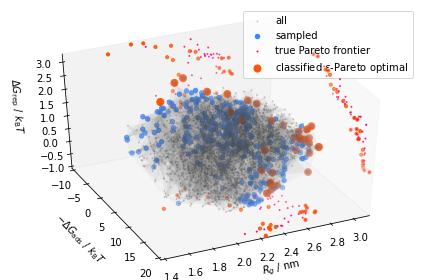

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(y[:,0], y[:,1], y[:,2], alpha=.3, s=1, c='gray',  label='all')
ax.plot_trisurf(y[:,0], y[:,1], y[:,2], color='gray', shade=True, 
                linewidth=0.01, edgecolor='none', alpha=.03)
ax.scatter(y[selected[-1],0], y[selected[-1],1], y[selected[-1],2], s=20, label='sampled', c=COLORS[3])



# True pareto frontier 
ax.scatter([3.1] * len(y[pareto_true_indices,0]), y[pareto_true_indices,1], y[pareto_true_indices,2], c=COLORS[2], 
            label='true Pareto frontier', s=1)
ax.scatter(y[pareto_true_indices, 0], [-10] * len(y[pareto_true_indices, 1]), y[pareto_true_indices,2], c=COLORS[2], 
            label='_nolegend_', s=1)
ax.scatter(y[pareto_true_indices,0], y[pareto_true_indices,1], [-1] * len(y[pareto_true_indices,2]), c=COLORS[2], 
            label='_nolegend_', s=1)


# e-PAL recovered
ax.scatter([3.1]*len(y[pareto_optimal[-1],0][pareto_indices_classified]), 
           y[pareto_optimal[-1],1][pareto_indices_classified],
           y[pareto_optimal[-1],2][pareto_indices_classified], 
           s=10, label='_nolegend_', c=COLORS[1])

ax.scatter(y[pareto_optimal[-1],0][pareto_indices_classified],
           y[pareto_optimal[-1],1][pareto_indices_classified], 
           [-1.0] * len(y[pareto_optimal[-1],2][pareto_indices_classified]), 
           s=10, label='_nolegend_', c=COLORS[1])

ax.scatter(y[pareto_optimal[-1],0][pareto_indices_classified],
           [-10] * len(y[pareto_optimal[-1],1][pareto_indices_classified]), 
           y[pareto_optimal[-1],2][pareto_indices_classified], 
           s=10, label='_nolegend_', c=COLORS[1])


# all Pareto classified 
ax.scatter(y[pareto_optimal[-1],0], y[pareto_optimal[-1],1], y[pareto_optimal[-1],2],s=50, c=COLORS[1],
           label='classified $\epsilon$-Pareto optimal')




# ax.xaxis.pane.fill = False
# ax.yaxis.pane.fill = False
# ax.zaxis.pane.fill = False

#ax.xaxis.pane.set_edgecolor('w')
#ax.yaxis.pane.set_edgecolor('w')
#ax.zaxis.pane.set_edgecolor('w')

ax.view_init(320, 115)
ax.legend(loc='upper right')
ax.grid(False)
ax.set_zlim(3.2, -1.0)
ax.set_xlim(1.4, 3.1)
ax.set_ylim(-10, 20)

ax.set_xlabel(r'$R_g$ / nm', labelpad=5)
ax.set_ylabel(r'$-\Delta G_\mathrm{ads}$ / $k_\mathrm{B}T$', labelpad=10)
ax.set_zlabel(r'$\Delta G_\mathrm{rep}$ / $k_\mathrm{B}T$', labelpad=10)


fig.tight_layout()

#fig.savefig('3d_pareto_trisurf.pdf', bbox_inches='tight')